In [126]:
from sklearn.datasets import load_files
import numpy as np
import keras.utils as np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import h5py
%matplotlib inline
plt.style.use("fivethirtyeight")

The goal of this tutorial is to look at how we could perform Transfer Learning using already existing, powerful models (inspiration from Francois Chollet's [excellent tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)). We can also learn a few Keras tricks on the way and explore visualization of CNN filters and activations! The data comes from Kaggle's competition [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) that was launched a few years ago. To keep it in line with the the tutorial, download the data from the Kaggle website and then run the ```file_structure.py``` script.

# Simple approach with data augmentation

The idea here is that we can perform data augmentation both to get more trainning examples, but also to avoid overfitting. This will slightly change we use Keras compared to scenarios with no data augmentation.

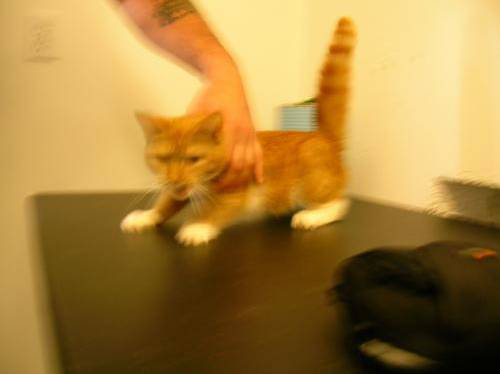

In [2]:
# Let's take a look at some image samples
cat_img = load_img("data/new_format/train/cats/cat.0.jpg")
cat_img

In [3]:
# convert to array
img_ar = img_to_array(cat_img)
print(img_ar.shape) # note that not all images are consistent in terms of pixel dimensions and they are in rgb
img_ar[:2]

(374, 500, 3)


array([[[ 203.,  164.,   87.],
        [ 203.,  164.,   87.],
        [ 204.,  165.,   88.],
        ..., 
        [ 240.,  201.,  122.],
        [ 239.,  200.,  121.],
        [ 238.,  199.,  120.]],

       [[ 203.,  164.,   87.],
        [ 203.,  164.,   87.],
        [ 204.,  165.,   88.],
        ..., 
        [ 241.,  202.,  123.],
        [ 240.,  201.,  122.],
        [ 238.,  199.,  120.]]], dtype=float32)

In [4]:
datagen = ImageDataGenerator(
        rotation_range=40, # max degree of rotation for the image
        width_shift_range=0.2, # max fraction along x axis to perform shift
        height_shift_range=0.2, # max fraction along y axis to perform shift
        rescale=1./255, # 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

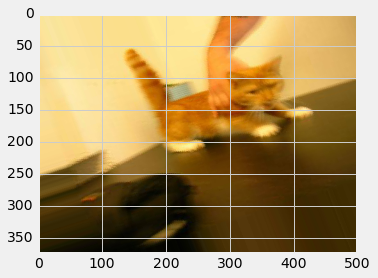

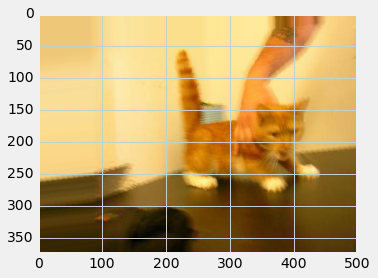

In [5]:
# let's see the types of images that will be generated now
i = 0

for batch in datagen.flow(img_ar.reshape((1,)+img_ar.shape), batch_size=1):
    plt.imshow(batch[0])
    i+=1
    plt.show()
    if i==2:
        break


# Attempt #1, a humble conv-net

Now that we have done our data preprocessing, it is time to see how well a simple convnet would do!

In [115]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Activation, Conv2D, Flatten, Dense, Dropout

simple_model = Sequential()

# Layer 1
simple_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation="relu"))
simple_model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
simple_model.add(Conv2D(32, (3, 3), activation="relu"))
simple_model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
simple_model.add(Conv2D(64, (3, 3), activation="relu"))
simple_model.add(MaxPooling2D(pool_size=(2,2)))

# Add some FC layers here and then a binary head
simple_model.add(Flatten()) # You can do some fancier stuff like Global Average Pooling (GAP)
simple_model.add(Dense(64, activation="relu"))
simple_model.add(Dropout(0.5)) # dropout with retention probability of 0.5
simple_model.add(Dense(1, activation="sigmoid"))

simple_model.summary() # Notice that we have A LOT of trainable parameters. All these are probably introduced by the FC layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 18496)             0         
__________

In [7]:
from keras.optimizers import Adam

# Time for some model trainning

opt = Adam() # Adam is usually the go to since it combines the best of RMSProp and Adadelta

simple_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

batch_size = 16
n_epochs = 50

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# technically we are not doing any permutations, just rescaling our validation images
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/new_format/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/new_format/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 20473 images belonging to 2 classes.
Found 4527 images belonging to 2 classes.


In [ ]:
# To keep track of the best model
checkpointer = ModelCheckpoint(filepath='models/simple_cnn_best.h5', 
                               verbose=1, save_best_only=True, monitor="val_loss")

history = simple_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[checkpointer])

In [8]:
simple_cnn = load_model("models/simple_cnn_best.h5")

# Using pre-trained networks for our task

There are two key limitations we should consider in our case. One is that we really don't have that much data to train a powerful classifier and the second one is that it is impractical to make and train a super large architecture (especially given some very limited computational capabilities).

As a result, we can use some pretrained models such as ```VGG 16```, ```Xception``` etc. that have been trained on similar task like the [imagenet classification challenge](http://www.image-net.org/). The task is fairly similar and we can use a pre-trained net from Keras to do the heavy lifting. Then all we have to do is fine-tune the model to use its extracted features for our task.

The way to do this is a not that complex but requires some care. Check F. Chollet's [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) on all the details.

In [9]:
# First, let's import a pretrained model from Keras
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet') # do not keep the model after the last convolutional block

base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

VGG is a very powerful architecture and would be great to use as a feature extractor for our task. In fact, we can also combine it with a linear SVM. This [paper](https://arxiv.org/abs/1306.0239) will tell you more about that.

However, before we do any of that, we need to figure out which layer of the net makes the best feature extractor. The way to do this is by passing a few images through the net, extracting and visualizing the produced embeddings using TSNE or the [tensorflow projector](projector.tensorflow.org/).

In [17]:
# First load some training data
import os

n_images = 50
cat_imgs = np.array(os.listdir("data/new_format/train/cats"))
dog_imgs = np.array(os.listdir("data/new_format/train/dogs"))

In [54]:
cat_sample_files = np.random.choice(cat_imgs, n_images, replace=False)
dog_sample_files = np.random.choice(dog_imgs, n_images, replace=False)

cat_sample = []
dog_sample = []
for i in np.arange(n_images):
    cat_sample.append(load_img("data/new_format/train/cats/"+cat_sample_files[i]))
    dog_sample.append(load_img("data/new_format/train/dogs/"+dog_sample_files[i]))
    
cat_sample = [img_to_array(f) for f in cat_sample]
dog_sample = [img_to_array(f) for f in dog_sample]
labels = [0]*50+[1]*50

In [58]:
simple_cnn.predict()

<bound method Sequential.predict of <keras.models.Sequential object at 0x115778a50>>

Instead of a flatten layer, a coworker suggested I try Global Average Pooling Layers a shot. They are quite interesting and the reasoning could apply in our case as well. Also they provide a reasonably high-dimensional representation that I can take through T-SNE right away without having to go through some other dimensionality reduction technique first.

Generating features
Start T-SNE


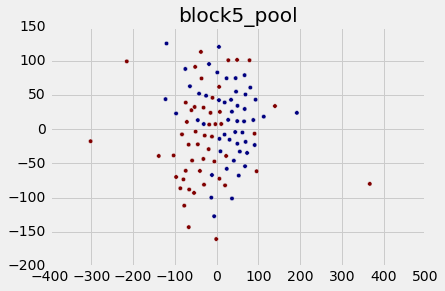

In [106]:
from keras.models import Model
from scipy.misc import imresize
from keras.layers import GlobalAveragePooling2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def extract_and_visualize(model, layer_name, X, y):
    """Given a base model, a layer name and a few images with labels, visualize the extracted features"""
    
    # rescale the incoming images to go through the net, dimensions are taken from imagenet
    X = np.array([imresize(ar, (256, 256, 3)) for ar in X])

    last_cnn = model.get_layer(layer_name).output
    add_gap = GlobalAveragePooling2D()(last_cnn) # pass the output of the network through a GAP 
    model = Model(inputs=model.input, outputs=add_gap)

    print("Generating features")
    features = model.predict(X)

    # Use T-SNE
    print("Start T-SNE")
    tsne = TSNE(n_components=2)
    two_d_feats = tsne.fit_transform(features)
    
    plt.scatter(two_d_feats[:, 0], two_d_feats[:, 1], c = labels)
    plt.title(layer_name)

extract_and_visualize(base_model, "block5_pool", cat_sample+dog_sample, labels)

Well, you canplay around with the parameters above to fine the best layer but I am gonna go with the whole network plus the GAP layer.

In [112]:
last_cnn = base_model.get_layer('block5_pool').output
add_gap = GlobalAveragePooling2D()(last_cnn) # pass the output of the network through a GAP 
extractor = Model(inputs=base_model.input, outputs=add_gap)

for l in extractor.layers:
    l.trainable = False

Now the training will be a two-stage process. First we attach a DNN on top of our extractor, freeze all the layers in the extractor and just learn the top DNN. Then, we unfreeze the layers and retrain the whole neural net end-to-end using a very small learning rate. The reason we have the first step is because when the weights from our DNN are randomly initialized, they will generate large gradients that may ruin all the nice features we have learned in the extractor. So we need the top network to have appropriate weights before we start training the whole pipeline.

In [128]:
x = Dense(100, activation='relu')(extractor.output)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
final_model = Model(inputs = extractor.input, outputs=x)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [ ]:
# Stage A) training

opt = Adam() # Adam is usually the go

# To keep track of the best model
checkpointer = ModelCheckpoint(filepath='models/frozen_extractor.h5', 
                               verbose=1, save_best_only=True, monitor="val_loss")

final_model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = final_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[checkpointer])

In [148]:
model = load_model("models/frozen_extractor.h5")

So how well does the model do in this case?

In [153]:
validation_loss, validation_acc = model.evaluate_generator(validation_generator, 100)
print("Validation Loss {}".format(validation_loss))
print("Validation Accuracy: {}".format(validation_acc))

Validation Loss 0.231185240969
Validation Accuracy: 0.905625


Now that we have finished our work with training th top-level network, we retrain the whole network end-to-end by unfreezing the layers of the extractor network. Remember that we are just fine-tuning so a low learning rate and vanilla SGD with momentum should do.

In [134]:
for l in model.layers:
    l.trainable = True
    
model.summary() # all parameters are trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [ ]:
from keras.optimizers import SGD

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='models/end_to_end_training.h5', 
                               verbose=1, save_best_only=True, monitor="val_loss")

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks=[checkpointer])

In [140]:
end_to_end = load_model("models/end_to_end_training.h5")

Clearly we have a lot of gains after fine tuning the whole network!

In [154]:
validation_loss, validation_acc = end_to_end.evaluate_generator(validation_generator, 100)
print("Validation Loss {}".format(validation_loss))
print("Validation Accuracy: {}".format(validation_acc))

Validation Loss 0.137985740767
Validation Accuracy: 0.941875
